# Testing MNIST Reader

In [1]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image


In [2]:
from core.yolov3 import YOLOV3

In [3]:
import os
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
mlp.rcParams["figure.facecolor"] = "white"

# Freezing


In [5]:
pb_file = "./yolov3_mnist_reader.pb"
ckpt_file = "./checkpoint/yolov3_test_loss=20.5142.ckpt-1.data-00000-of-00001"
output_node_names = ["input/input_data", "pred_sbbox/concat_2", "pred_mbbox/concat_2", "pred_lbbox/concat_2"]

In [6]:
with tf.name_scope('input'):
    input_data = tf.placeholder(dtype=tf.float32, name='input_data')

In [7]:
model = YOLOV3(input_data, trainable=False)
print(model.conv_sbbox, model.conv_mbbox, model.conv_lbbox)

Tensor("conv_sbbox/BiasAdd:0", shape=(?, ?, ?, 45), dtype=float32) Tensor("conv_mbbox/BiasAdd:0", shape=(?, ?, ?, 45), dtype=float32) Tensor("conv_lbbox/BiasAdd:0", shape=(?, ?, ?, 45), dtype=float32)


In [8]:
sess  = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
saver = tf.train.Saver()

In [9]:
saver.restore(sess,tf.train.latest_checkpoint("checkpoint"))

INFO:tensorflow:Restoring parameters from checkpoint/yolov3_test_loss=32.7316.ckpt-3


In [10]:
converted_graph_def = tf.graph_util.convert_variables_to_constants(sess,
                            input_graph_def  = sess.graph.as_graph_def(),
                            output_node_names = output_node_names)



INFO:tensorflow:Froze 366 variables.
INFO:tensorflow:Converted 366 variables to const ops.


In [11]:
with tf.gfile.GFile(pb_file, "wb") as f:
    f.write(converted_graph_def.SerializeToString())


# Read image

In [12]:

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_mnist_reader.pb"
image_path      = "./output_data/test-0.jpg"
num_classes     = 10
input_size      = 416
graph           = tf.Graph()


In [13]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...]


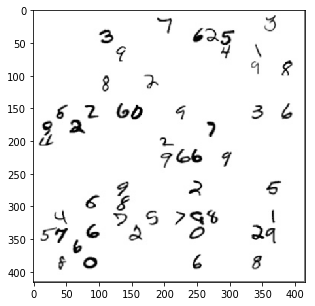

In [14]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(image_data[0])

In [15]:
return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)


with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run(
        [return_tensors[1], return_tensors[2], return_tensors[3]],
                feed_dict={ return_tensors[0]: image_data})



Instructions for updating:
Use tf.gfile.GFile.


In [16]:
pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)


In [17]:
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.15)
bboxes = utils.nms(bboxes, 0.45, method='nms')

In [18]:
bboxes[0]

array([6.18862343e+01, 3.21878845e+02, 8.79271317e+01, 3.44602325e+02,
       1.91771805e-01, 0.00000000e+00])

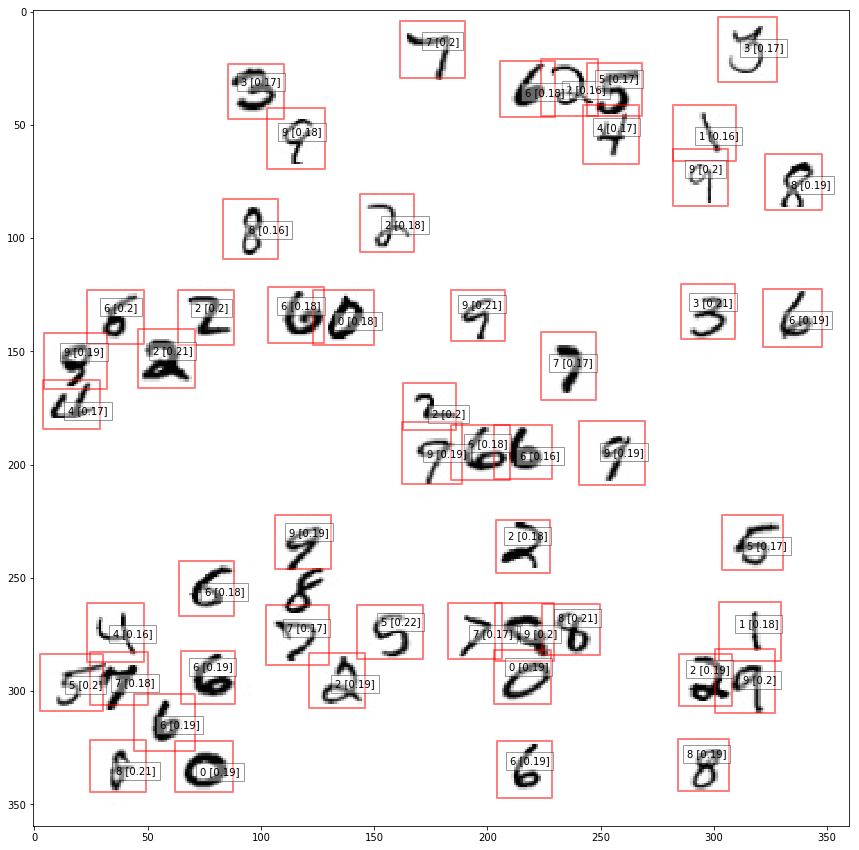

In [19]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(original_image)
rects = [ Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1]) for x in bboxes ]
ax = plt.gca()
pc = PatchCollection(rects, facecolor="None", alpha=0.5, linewidth=2,
                     edgecolor="red", )
ax.add_collection(pc)
for i, box in enumerate(bboxes):
    plt.text(box[0]+20 if i%2 == 0 else box[2]-10, box[1]+15 if i%2 == 0 else box[3]-15, 
             str(int(box[5])) + " [" + str(np.round(box[4],2)) + "]" , bbox=dict(facecolor='white', alpha=0.4), horizontalalignment="center" )

# Testing on an elections sheet real image

In [66]:
image_path      = "./demo/acta4.jpg"

In [67]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


In [78]:
original_image = original_image[100:1200,100:1300,:]

In [79]:
original_image = cv2.blur(original_image,(5,5))

In [80]:
input_size      = 416

In [81]:
original_image_size = original_image.shape[:2]
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...]


In [82]:
return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)


with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run(
        [return_tensors[1], return_tensors[2], return_tensors[3]],
                feed_dict={ return_tensors[0]: image_data})



In [83]:
pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)


In [84]:
pred_mbbox.shape

(1, 26, 26, 3, 15)

In [85]:
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.10)
bboxes = utils.nms(bboxes, 0.45, method='nms')

In [86]:
bboxes[0]

array([3.54064606e+02, 5.73971436e+02, 4.38259857e+02, 6.46784119e+02,
       2.04803154e-01, 0.00000000e+00])

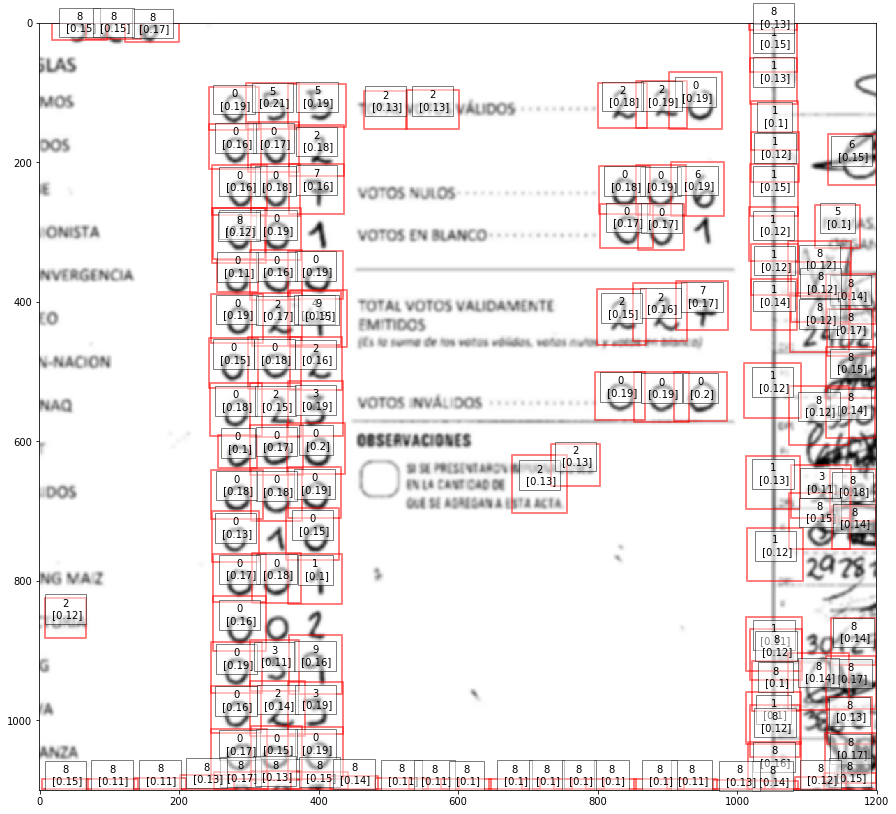

In [87]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(original_image)
rects = [ Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1]) for x in bboxes ]
ax = plt.gca()
pc = PatchCollection(rects, facecolor="None", alpha=0.5, linewidth=2,
                     edgecolor="red", )
ax.add_collection(pc)
for i, box in enumerate(bboxes):
    plt.text((box[0]+box[2])/2, (box[1]+box[3])/2, 
             str(int(box[5])) + "\n [" + str(np.round(box[4],2)) + "]" , bbox=dict(facecolor='white', alpha=0.5), horizontalalignment="center" )